In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/s12gb1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data preparation

In [2]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb['train'], imdb['test']

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                  min_freq = 3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "</s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [4]:
seq_length = 500
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=500):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])
        
        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) -1
            text_processed = text_processed + [vocab["</s>"]] + [vocab["<pad>"]]*pad_size
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return (input_ids, labels)

In [5]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

# 2. Model

In [6]:
class TextClsModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.bi_lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, 2)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.bi_lstm(x)
        last_hidden =torch.concat((hidden[-1,:,:], hidden[-2,:,:]), dim=1)
        x = self.fc(last_hidden)
        return x

In [7]:
model = TextClsModel(vocab_size=vocab_size, 
                     emb_dim=128, 
                     hidden_dim=64,
                     num_layers=2
                     )


In [8]:
from torchsummary import summary

random_tensor = torch.randint(low=0, high=vocab_size, size=(64, seq_length), dtype=torch.long)
summary(model, random_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 500, 128]            2,560,000
├─LSTM: 1-2                              [-1, 500, 128]            198,656
├─Linear: 1-3                            [-1, 2]                   258
Total params: 2,758,914
Trainable params: 2,758,914
Non-trainable params: 0
Total mult-adds (M): 2.76
Input size (MB): 0.12
Forward/backward pass size (MB): 0.98
Params size (MB): 10.52
Estimated Total Size (MB): 11.62


Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 500, 128]            2,560,000
├─LSTM: 1-2                              [-1, 500, 128]            198,656
├─Linear: 1-3                            [-1, 2]                   258
Total params: 2,758,914
Trainable params: 2,758,914
Non-trainable params: 0
Total mult-adds (M): 2.76
Input size (MB): 0.12
Forward/backward pass size (MB): 0.98
Params size (MB): 10.52
Estimated Total Size (MB): 11.62

# 3. Evalute

In [9]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

# 4. Train

In [10]:
device = 'cuda'
max_epoch = 20
LR = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [11]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 0.5415, Accuracy: 70.42%, Test Loss: 0.3157, Test Accuracy: 86.88%
Epoch [2/20], Loss: 0.2267, Accuracy: 91.23%, Test Loss: 0.3036, Test Accuracy: 87.88%
Epoch [3/20], Loss: 0.1198, Accuracy: 95.87%, Test Loss: 0.3444, Test Accuracy: 86.74%
Epoch [4/20], Loss: 0.0763, Accuracy: 97.51%, Test Loss: 0.3967, Test Accuracy: 86.52%
Epoch [5/20], Loss: 0.0663, Accuracy: 97.80%, Test Loss: 0.4481, Test Accuracy: 86.24%
Epoch [6/20], Loss: 0.0431, Accuracy: 98.64%, Test Loss: 0.5002, Test Accuracy: 86.51%
Epoch [7/20], Loss: 0.0434, Accuracy: 98.57%, Test Loss: 0.5150, Test Accuracy: 85.81%
Epoch [8/20], Loss: 0.0368, Accuracy: 98.74%, Test Loss: 0.5247, Test Accuracy: 85.71%
Epoch [9/20], Loss: 0.0291, Accuracy: 98.98%, Test Loss: 0.5739, Test Accuracy: 86.29%
Epoch [10/20], Loss: 0.0225, Accuracy: 99.27%, Test Loss: 0.6619, Test Accuracy: 85.14%
Epoch [11/20], Loss: 0.0278, Accuracy: 99.11%, Test Loss: 0.6664, Test Accuracy: 84.29%
Epoch [12/20], Loss: 0.0322, Accuracy: 98

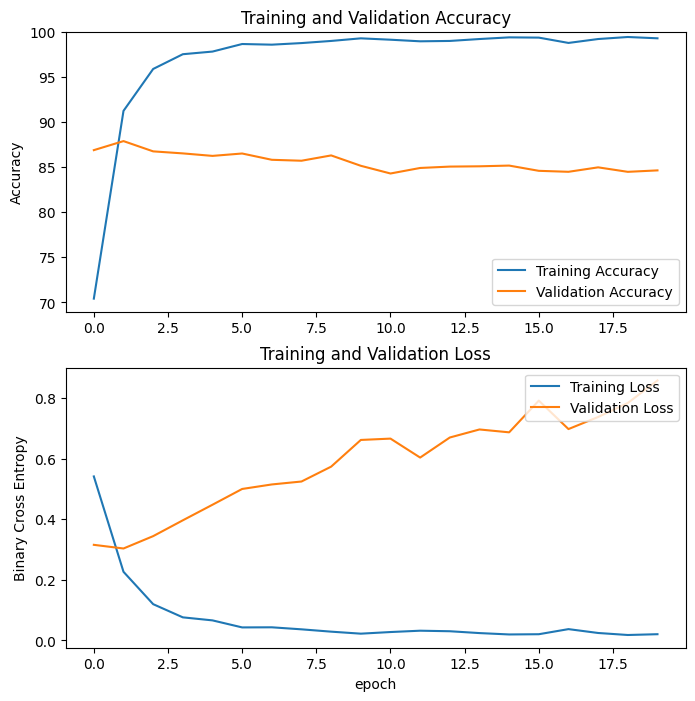

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()